In [2]:
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Connecting to the Database
print("Trying to connect to db")
conn = psycopg2.connect(
    database="piscineds",
    user="ggobert",
    password="mysecretpassword",
    host=0
)
print("Connection success!")

cur = conn.cursor()
cur.execute("""
    WITH purchases AS (
        SELECT 
            user_id,
            event_time,
            CAST(REPLACE(REPLACE(price::text, '$', ''), ',', '') AS FLOAT) AS price
        FROM 
            customers
        WHERE 
            event_type = 'purchase'
    ),

    last_date AS (
        SELECT 
            MAX(event_time) AS max_date
        FROM 
            purchases
    ),

    rfm_base AS (
        SELECT 
            p.user_id,
            MAX(p.event_time) AS last_purchase,
            COUNT(*) AS frequency,
            SUM(p.price) AS monetary
        FROM 
            purchases p
        GROUP BY 
            p.user_id
    )

    SELECT 
        EXTRACT(DAY FROM (l.max_date - r.last_purchase)) AS recency,
        r.frequency,
        r.monetary
    FROM 
        rfm_base r, last_date l;
""")
results = cur.fetchall()

cur.close()
conn.close()

Trying to connect to db
Connection success!


In [4]:
rfm = pd.DataFrame(results, columns=["recency", "frequency", "monetary"])
rfm = rfm.astype(float)

In [5]:
# IQR, enlever les outliers

Q1 = rfm.quantile(0.25)
Q3 = rfm.quantile(0.75)
IQR = Q3 - Q1

rfm_iqr = rfm[~((rfm < (Q1 - 1.5 * IQR)) | (rfm > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
# Standardiser

scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_iqr)

scaled_rfm = pd.DataFrame(scaled_rfm, columns=["recency", "frequency", "monetary"])

In [7]:
# Elbow method

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_rfm)
    inertia.append(kmeans.inertia_)

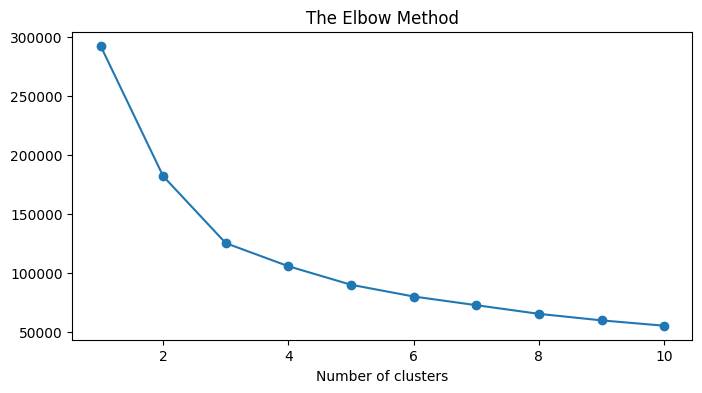

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.show()

In [9]:
# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_rfm)

KMeans(n_clusters=4, random_state=42)

In [10]:
scaled_rfm['cluster'] = kmeans.labels_

In [11]:
# Moyenne des scores
cluster_scores = scaled_rfm.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
})

# Classement
cluster_scores['recency_rank'] = cluster_scores['recency'].rank(ascending=True)  # Récence : plus petit est mieux
cluster_scores['frequency_rank'] = cluster_scores['frequency'].rank(ascending=False)  # Fréquence : plus grand est mieux
cluster_scores['monetary_rank'] = cluster_scores['monetary'].rank(ascending=False)  # Montant monétaire : plus grand est mieux

# Fonction pour attribuer un label basé sur les rangs
def name_label_cluster(row):
    if row['recency_rank'] == 4:  # Le cluster avec la récence la plus faible (le plus récent)
        return 'inactive'
    elif row['recency_rank'] == 1:
        return 'new'  # Si recency est élevé, mais fréquence et montant faibles
    elif row['frequency_rank'] == 1 and row['monetary_rank'] == 1:
        return 'platinum'  # Le cluster avec la fréquence et le montant les plus élevés
    else:
        return 'regular'  # Clusters intermédiaires
cluster_scores['label'] = cluster_scores.apply(name_label_cluster, axis=1)

# Colonne label en dict
label_mapping = cluster_scores['label'].to_dict()

# application du dict
scaled_rfm['cluster'] = scaled_rfm['cluster'].map(label_mapping)

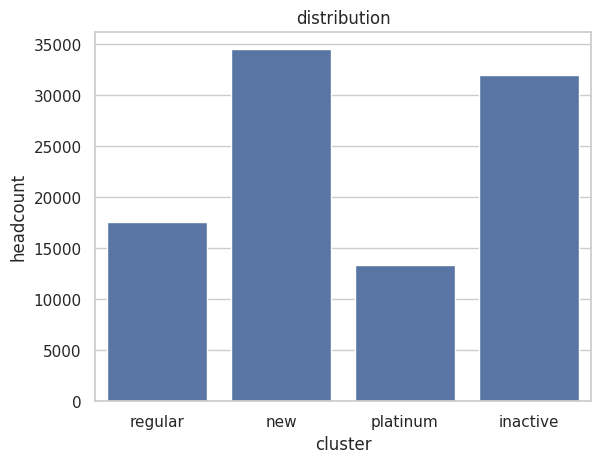

In [12]:
sns.set(style="whitegrid")

sns.countplot(x='cluster', data=scaled_rfm)

plt.title("distribution")
plt.xlabel("cluster")
plt.ylabel("headcount")
plt.show()

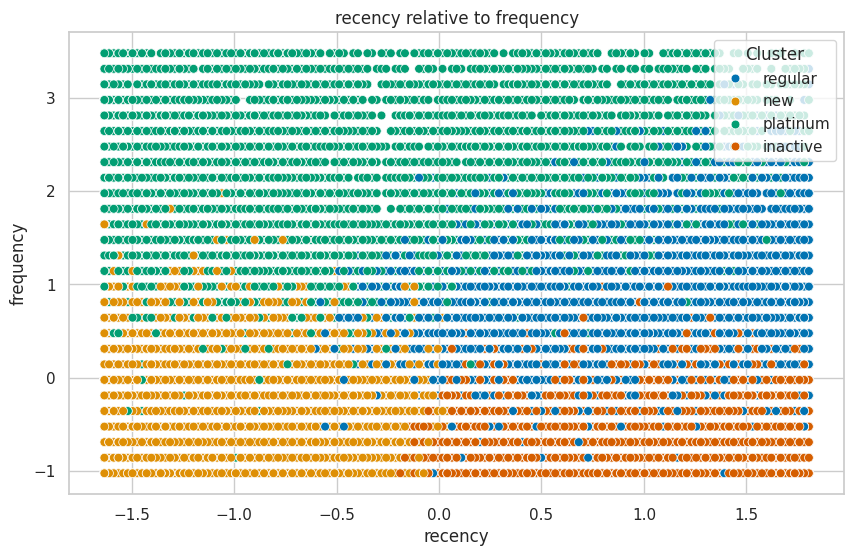

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scaled_rfm, x='recency', y='frequency', hue='cluster', palette='colorblind', s=40)


plt.title("recency relative to frequency")
plt.xlabel("recency")
plt.ylabel("frequency")

plt.legend(title='Cluster', loc='upper right')
plt.show()

In [14]:
scaled_rfm

,recency,frequency,monetary,cluster
0,1.507404,-0.192656,1.040995,regular
1,-1.381533,0.475696,0.555010,new
2,-1.335677,1.645313,1.923492,platinum
3,0.223432,0.809872,0.215088,regular
4,1.278123,-0.025568,0.093878,regular
...,...,...,...,...
97458,1.186411,-0.025568,1.656602,regular
97459,0.452713,-0.861009,-0.986684,inactive
97460,-1.358605,-1.028097,-0.822649,new
97461,0.659065,1.812401,3.335564,platinum
